In [2]:
import numpy as np
import os
import cv2
import h5py
import tensorflow as tf
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as keras
import h5py
import matplotlib.pyplot as plt
import math
import sys

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install h5py for working with HDF5 files
!pip install h5py

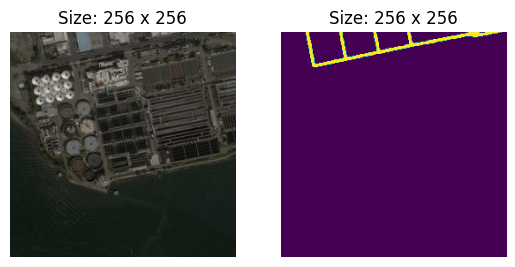

In [ ]:
#To Display Images in Massachusetts Dataset

file_path = '/content/drive/MyDrive/Road Safety/datasets/Dataset_test.h5'

with h5py.File(file_path, 'r') as file:
    # Assuming the dataset containing images is named "images"
    images_dataset = file['images']

    # Display the first few images and their sizes
    num_images_to_display = 1
    for i in range(num_images_to_display):
        # Access the image and its size
        image = images_dataset[i]
        image_size = image.shape

        # Display the image
        plt.subplot(1, 2, i + 1)
        plt.imshow(image)
        plt.title(f'Size: {image_size[0]} x {image_size[1]}')
        plt.axis('off')
    image_mask = file["masks"]
    plt.subplot(1, 2, 2)
    plt.imshow(image_mask[0])
    plt.title(f'Size: {image_size[0]} x {image_size[1]}')
    plt.axis('off')
    plt.show()


In [ ]:
# Model and loss formulae Definition

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou


def unet(input_size = (256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(inputs)

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(pool1)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(pool2)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(pool3)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv4)

    drop4 = Dropout(0.5)(conv4)

    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same',
                                                 kernel_initializer = 'he_normal'
                                                 )(pool4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same',
                                                 kernel_initializer = 'he_normal'
                                                 )(conv5)

    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(drop5))

    merge6 = concatenate([drop4,up6])

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge6)

    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv6))

    merge7 = concatenate([conv3,up7])

    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge7)

    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal'
                                                )(conv7)


    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(UpSampling2D(size = (2,2))(conv7))

    merge8 = concatenate([conv2,up8])

    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(merge8)

    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same',
                                                kernel_initializer = 'he_normal'
                                                )(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same',
                                             kernel_initializer = 'he_normal'
                                             )(UpSampling2D(size = (2,2))(conv8))

    merge9 = concatenate([conv1,up9])

    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(merge9)

    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same',
                                               kernel_initializer = 'he_normal'
                                               )(conv9)

    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same',
                                              kernel_initializer = 'he_normal'
                                              )(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-3), loss = 'binary_crossentropy', metrics = [dice_coef, iou_coef])


    return model

In [ ]:
#Processing for pretraining then model
print('*'*30)
print('Loading and preprocessing train data...')
print('*'*30)
file = h5py.File('/content/drive/MyDrive/Road Safety/datasets/Dataset_train.h5', 'r')
img_train = file.get('images')
mask_train = file.get('masks')
img_train = np.array(img_train)
mask_train = np.array(mask_train)

img_train = img_train.astype('float32')
img_train /= 255

mask_train = mask_train.astype('float32')
# mask_train /= 255  # scale masks to [0, 1]
mask_train = (mask_train > 0.5).astype(np.float32)

print(len(img_train))
print(img_train[0].shape)

print(len(mask_train))
print(mask_train[0].shape)

print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = unet()

******************************
Loading and preprocessing train data...
******************************
2087
(256, 256, 3)
2087
(256, 256, 1)
******************************
Creating and compiling model...
******************************


In [ ]:
model.summary()

In [ ]:
#Pretraining model
print('*'*30)
print('Fitting model...')
print('*'*30)

epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(f'weights_bceloss_{epochs}epochs.h5', monitor='val_loss', save_best_only=True)

history =  model.fit(img_train, mask_train, batch_size=16, epochs=epochs, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint, early_stopping])

******************************
Fitting model...
******************************
Epoch 1/100
  3/105 [..............................] - ETA: 1:49 - loss: 0.9914 - dice_coef: 0.1883 - iou_coef: 0.1014

KeyboardInterrupt: ignored

In [ ]:
#Saving Pretrained model Weights and Predicting with Pretrained model
file = h5py.File('/content/drive/MyDrive/Road Safety/datasets/Dataset_test.h5', 'r')
img_test = file.get('images')
mask_test = file.get('masks')
img_test = np.array(img_test)
mask_test = np.array(mask_test)
img_test = img_test.astype('float32')

img_test /= 255

print('*'*30)
print('Loading saved weights...')
print('*'*30)
model.load_weights('/content/drive/MyDrive/Road Safety/datasets/weights_bceloss_100epochs.h5')

print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
mask_pred = model.predict(img_test, verbose=1)


******************************
Loading saved weights...
******************************
******************************
Predicting masks on test data...
******************************
1/1 [==============================] - 46s 46s/step


******************************
Saving predicted masks to files...
******************************
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


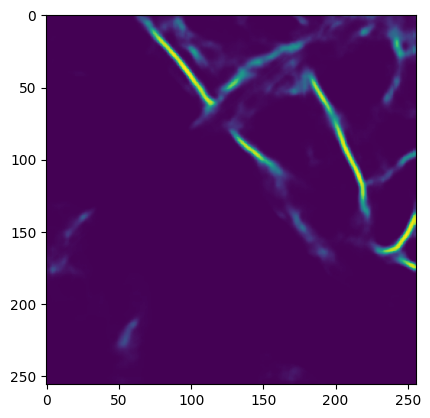

In [ ]:
#Saving predictions from Pretrained model
print('*' * 30)
print('Saving predicted masks to files...')
print('*' * 30)
pred_dir = 'Preds2'
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for i, image in enumerate(mask_pred):
    image = (image * 255).astype(np.uint8)
    print(i)
    plt.imshow(image)
    cv2.imwrite(os.path.join(pred_dir, str(i + 1) + '_pred.png'), image)
    # plt.imshow(image)
# plt.subplot(1, 2, 1)
# plt.imshow(mask_pred[3])
# plt.subplot(1, 2, 2)
# plt.imshow(mask_test[3])
# print(/content/Preds2/1_pred.png)
# plt.imshow("/content/Preds2/1_pred.png")


In [ ]:
plt.figure(figsize=(60, 30))
plt.plot(history.history['loss'], linewidth=8, color='r')                   #visualising training and validation loss curves
plt.plot(history.history['val_loss'], linewidth=8, color='b')
plt.title('Model train vs Validation Loss', fontsize=100, fontweight="bold")
plt.ylabel('Loss', fontsize=80)
plt.xlabel('Epoch', fontsize=80)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=50)
plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.show()

NameError: ignored

<Figure size 6000x3000 with 0 Axes>

In [ ]:
# COnverting 3 channel rgb masks to 1 channel Grayscale images
import os
import cv2

#To convert rgb masks tot greyscale

# Path to the folder containing RGB images
rgb_folder_path = '/content/drive/MyDrive/Road Safety/datasets/train_masks'

# Path to the folder where grayscale images will be saved
grayscale_folder_path = '/content/drive/MyDrive/Road Safety/datasets/train_masks2'

# Create the grayscale folder if it doesn't exist
os.makedirs(grayscale_folder_path, exist_ok=True)

# Function to convert red to white and save as grayscale
def convert_red_to_white(rgb_image_path, save_path):
    rgb_image = cv2.imread(rgb_image_path)

    # Extract only the red channel
    red_channel = rgb_image[:, :, 2]

    # Set red pixels to white
    red_channel[red_channel > 0] = 255

    # Create a single-channel grayscale image
    grayscale_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)

    # Save the grayscale image
    cv2.imwrite(save_path, grayscale_image)

# Loop through each RGB image in the folder
for rgb_filename in os.listdir(rgb_folder_path):
    if rgb_filename.endswith('.jpg') or rgb_filename.endswith('.png'):
        rgb_image_path = os.path.join(rgb_folder_path, rgb_filename)
        grayscale_image_path = os.path.join(grayscale_folder_path, rgb_filename.replace('.jpg', '_gray.jpg').replace('.png', '_gray.png'))

        # Convert and save the red-to-white grayscale image
        convert_red_to_white(rgb_image_path, grayscale_image_path)

print("Conversion complete.")

Conversion complete.


In [ ]:
#Training Pretrained model with custom dataset

import os

print('*'*30)
print('Loading and preprocessing train data...')
print('*'*30)
# Path to the folder containing images on your Google Drive
folder_path = '/content/drive/MyDrive/Road Safety/datasets/train_images'

# List the files in the folder
image_files = os.listdir(folder_path)

# Initialize an empty list to store image arrays
img_train = []
target_size = (256,256)
# Loop through each image file in the folder
for file_name in image_files:
    # Construct the full path to the image
    full_path = os.path.join(folder_path, file_name)

    # Read the image using OpenCV
    image = cv2.imread(full_path)
    # original_size = cv2.imread(full_path).shape[:2]
    # print(f"Original size of {file_name}: {original_size}")
    image = cv2.resize(image, target_size)
    # Append the image array to the list
    img_train.append(image)

# Convert the list of arrays to a NumPy array
img_train = np.array(img_train)
img_train = img_train.astype('float32')
img_train /= 255

folder_path = '/content/drive/MyDrive/Road Safety/datasets/train_masks'

# List the files in the folder
image_files = os.listdir(folder_path)

# Initialize an empty list to store image arrays
img_masks = []
# Loop through each image file in the folder
for file_name in image_files:
    # Construct the full path to the image
    full_path = os.path.join(folder_path, file_name)

    # Read the image using OpenCV
    image = cv2.imread(full_path)
    # original_size = cv2.imread(full_path).shape[:2]
    # print(f"Original size of {file_name}: {original_size}")
    image = cv2.resize(image, target_size)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Expand dimensions to make it 256x256x1
    image = image[:, :, np.newaxis]
    # Append the image array to the list
    img_masks.append(image)

# Convert the list of arrays to a NumPy array
img_masks = np.array(img_masks)
img_masks = img_masks.astype('float32')
img_masks = (img_masks > 0.5).astype(np.float32)

# print(len(img_masks))
# print(len(img_train))
# print(img_train[0].shape)
# print(img_masks[0].shape)
# plt.imshow(img_masks[0])
# plt.imshow(img_masks[0])


print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = unet()
print('*'*30)
print('Loading saved weights...')
print('*'*30)
model.load_weights('/content/drive/MyDrive/Road Safety/datasets/weights_bceloss_100epochs.h5')

#Pretraining model
print('*'*30)
print('Fitting model...')
print('*'*30)

epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/Road Safety/datasets/weights_bceloss_custom_dataset{epochs}epochs.h5', monitor='val_loss', save_best_only=True)

history =  model.fit(img_train, img_masks, batch_size=16, epochs=epochs, verbose=1, shuffle=True,
          validation_split=0.2,
          callbacks=[model_checkpoint, early_stopping])


******************************
Loading and preprocessing train data...
******************************
******************************
Creating and compiling model...
******************************
******************************
Loading saved weights...
******************************
******************************
Fitting model...
******************************
Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.9177 - dice_coef: 0.1842 - iou_coef: 0.1062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 62s 4s/step - loss: 0.9177 - dice_coef: 0.1842 - iou_coef: 0.1062 - val_loss: 0.4367 - val_dice_coef: 0.2051 - val_iou_coef: 0.1138
Epoch 2/100
8/8 [==============================] - 9s 1s/step - loss: 0.3035 - dice_coef: 0.4780 - iou_coef: 0.3305 - val_loss: 0.6701 - val_dice_coef: 0.3699 - val_iou_coef: 0.2764
Epoch 3/100
8/8 [==============================] - 9s 1s/step - loss: 0.2607 - dice_coef: 0.6437 - iou_coef: 0.5038 - val_loss: 0.4712 - val_dice_coef: 0.3000 - val_iou_coef: 0.1916
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 0.2442 - dice_coef: 0.6023 - iou_coef: 0.4465 - val_loss: 0.5728 - val_dice_coef: 0.2809 - val_iou_coef: 0.1836
Epoch 5/100
8/8 [==============================] - 10s 1s/step - loss: 0.2437 - dice_coef: 0.6378 - iou_coef: 0.4858 - val_loss: 0.5625 - val_dice_coef: 0.3698 - val_iou_coef: 0.2672
Epoch 6/100
8/8 [==============================] - 9s 1s/step - loss: 0.2341 - dice_coef: 0.6666 - 

In [ ]:
# Testing final Model

import os
# Path to the folder containing images on your Google Drive
folder_path = '/content/drive/MyDrive/Road Safety/naip2'

# List the files in the folder
image_files = os.listdir(folder_path)

# Initialize an empty list to store image arrays
img_test = []
target_size = (256,256)
# Loop through each image file in the folder
for file_name in image_files:
    # Construct the full path to the image
    full_path = os.path.join(folder_path, file_name)

    # Read the image using OpenCV
    image = cv2.imread(full_path)
    # original_size = cv2.imread(full_path).shape[:2]
    # print(f"Original size of {file_name}: {original_size}")
    image = cv2.resize(image, target_size)
    # Append the image array to the list
    img_test.append(image)

# Convert the list of arrays to a NumPy array
img_test = np.array(img_test)
img_test = img_test.astype('float32')
img_test /= 255

# print(len(img_test))
# print(img_test[0].shape)
print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = unet()
print('*'*30)
print('Loading saved weights...')
print('*'*30)
model.load_weights('/content/drive/MyDrive/Road Safety/datasets/weights_bceloss_custom_dataset100epochs.h5')

print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
mask_pred = model.predict(img_test, verbose=1)

******************************
Creating and compiling model...
******************************
******************************
Loading saved weights...
******************************
******************************
Predicting masks on test data...
******************************


1/1 [==============================] - 0s 244ms/step


******************************
Saving predicted masks to files...
******************************


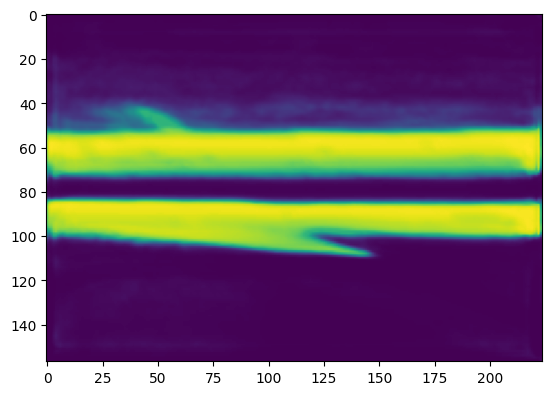

In [ ]:
#Saving Final Predictions
print('*' * 30)
print('Saving predicted masks to files...')
print('*' * 30)
pred_dir = '/content/drive/MyDrive/Road Safety/naip_test_Preds2'
target_size = (224,157)
if not os.path.exists(pred_dir):
    os.mkdir(pred_dir)
for i, image in enumerate(mask_pred):
    image = cv2.resize(image,target_size)
    image = (image * 255).astype(np.uint8)
    plt.imshow(image)
    cv2.imwrite(os.path.join(pred_dir, str(i + 1) + '_naip_pred.png'), image)

Sorted Points: [(0, 43), (0, 70), (0, 83), (116, 86), (223, 57)]
Coordinates: [(116, 86), (0, 83), (0, 70), (223, 57), (0, 43)]
Widths:  [27.0, 13.0, 110.86027241532469]
5
Widths are :  [27.0, 116.03878661895772]


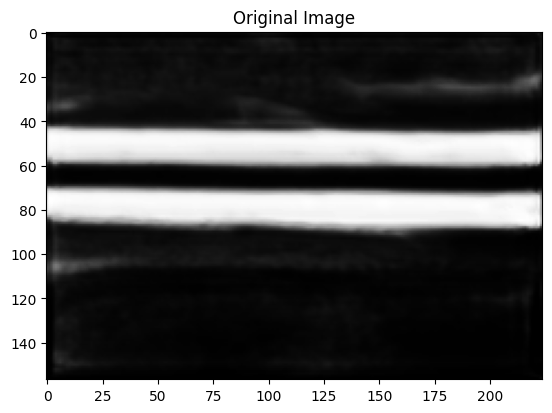

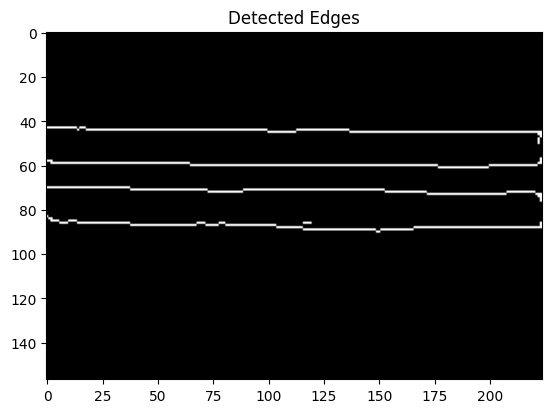

In [ ]:
# Function to display images inline in Colab
def display_image(image, title):
    plt.imshow(image, cmap='gray')
    plt.title(title)
    # plt.axis('off')
    plt.show()

# Function to print start and end pixels for each contour
def print_start_end_pixels(contour):
    start_pixel = tuple(contour[0][0])
    end_pixel = tuple(contour[-1][0])
    print(f"Start Pixel: {start_pixel}, End Pixel: {end_pixel}")

def findCoordinates(contours):
  coordinates = []
  for contour in contours:
    start_pixel = tuple(contour[0][0])
    coordinates.append(start_pixel)
  return coordinates

# Function to calculate Euclidean distance between two points
def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)


# Function to find the closest distance for each coordinate
def find_closest_distances(coordinates):
    unique_distances = set()
    for i in range(len(coordinates)):
        current_point = coordinates[i]
        distance = sys.maxsize
        for j in range(len(coordinates)):
            if i != j:
                distance = min(distance,euclidean_distance(current_point, coordinates[j]))
        unique_distances.add(distance)

    closest_distances = list(unique_distances)

    return closest_distances

def find_dist_pairs(coordinates):
  distances = []
  print(len(coordinates))
  for i in range(len(coordinates)):
    if ((i%2 == 0) and (i+1<len(coordinates))):
      distances.append(euclidean_distance(coordinates[i],coordinates[i+1]))
  return distances


# Load segmentation mask
mask_path = '/content/drive/MyDrive/Road Safety/naip_test_Preds2/1_naip_pred.png'
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
blurred = cv2.GaussianBlur(src=mask, ksize=(3, 5), sigmaX=0.5)
# Edge detection
edges = cv2.Canny(blurred, 220, 255)

# Contour detection
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


coordinates = findCoordinates(contours)

# Sorting by x and then y
sorted_points = sorted(coordinates, key=lambda point: (point[0], point[1]))

print("Sorted Points:", sorted_points)


print("Coordinates:",coordinates)
print("Widths: ",find_closest_distances(coordinates))

print("Widths are : ", find_dist_pairs(sorted_points))

# Display the original image
display_image(mask, 'Original Image')

# Display the detected edges
display_image(edges, 'Detected Edges')




Rectangle 1 Dimensions: Width = 223, Height = 16, Location: (x = 0, y = 72)
Rectangle 2 Dimensions: Width = 223, Height = 14, Location: (x = 0, y = 45)
Rectangle 1 Dimensions: Width = 222.1443634033203, Height = 12.458666801452637, Location: (x = 111.01231384277344, y = 79.50947570800781)
Rectangle 2 Dimensions: Width = 222.04742431640625, Height = 11.297554016113281, Location: (x = 111.03470611572266, y = 51.38975524902344)


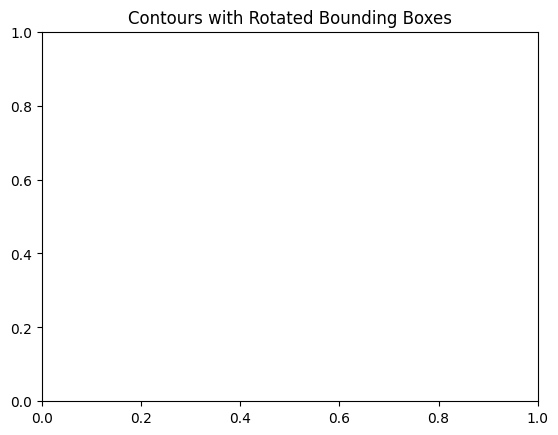

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Load the image
image = cv2.imread('/content/drive/MyDrive/Road Safety/naip_test_Preds2/1_naip_pred.png')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary image
_, threshold = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours
min_contour_area = 100  # You may need to adjust this value based on your specific image
filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area]

# Draw the contours on a copy of the original image
contour_image = image.copy()
cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)

# # Display the results using matplotlib
plt.figure(figsize=(10, 5))

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

# Display the image with contours
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Image with Contours')

plt.show()

for i, contour in enumerate(filtered_contours):
    x, y, w, h = cv2.boundingRect(contour)
    if x<=1:
      print(f"Rectangle {i + 1} Dimensions: Width = {w}, Height = {h}, Location: (x = {x}, y = {y})")

for i, contour in enumerate(filtered_contours):
    # Use minAreaRect to get a rotated bounding box
    rect = cv2.minAreaRect(contour)
    w, h = rect[1]
    x, y = rect[0]
    print(f"Rectangle {i + 1} Dimensions: Width = {w}, Height = {h}, Location: (x = {x}, y = {y})")
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Ensure the vertices are in the correct order
    box = sorted(box, key=lambda x: x[0])

    # Plot the rotated bounding box
    polygon = Polygon(box, edgecolor='r', facecolor='none')
    plt.gca().add_patch(polygon)



# Show the plot
plt.title('Contours with Rotated Bounding Boxes')
plt.show()


Rectangle Dimensions: Width = 7.0710678118654755, Height = 135.71293232407882, Coordinates: [array([ 1, 70]), array([ 0, 63]), array([133,  36]), array([134,  43])]
Rectangle Dimensions: Width = 2.0, Height = 1.0, Coordinates: [array([219,  24]), array([217,  24]), array([217,  23]), array([219,  23])]


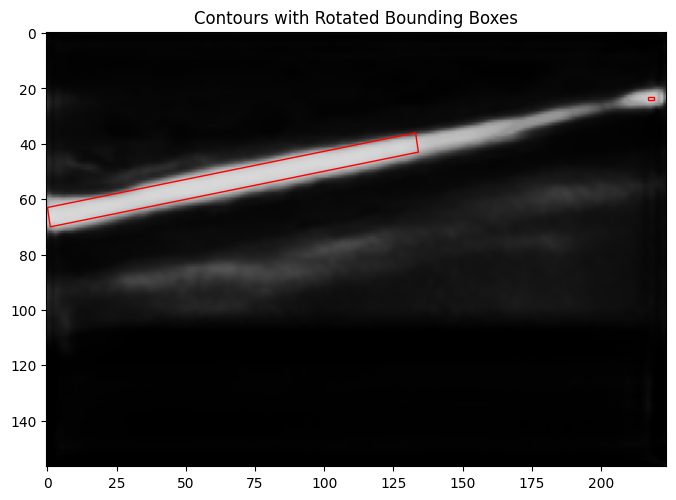

In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

# Load the image
image = cv2.imread('/content/drive/MyDrive/Road Safety/naip_test_Preds/1_naip_pred.png')

# Convert the image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary image
_, threshold = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)

# Find contours in the binary image
contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter out small contours
min_contour_area = 0 # You may need to adjust this value based on your specific image
filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > min_contour_area]

# Create a figure and axis for plotting
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Plot the contours
for contour in filtered_contours:
    # Use minAreaRect to get a rotated bounding box
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    # Sort the vertices in counterclockwise order
    box = sorted(box, key=lambda x: (np.arctan2(x[1] - rect[0][1], x[0] - rect[0][0]) + 2 * np.pi) % (2 * np.pi))

    # Plot the rotated bounding box
    polygon = Polygon(box, edgecolor='r', facecolor='none')
    plt.gca().add_patch(polygon)
    width = np.linalg.norm(box[0] - box[1])
    height = np.linalg.norm(box[1] - box[2])
    print(f"Rectangle Dimensions: Width = {width}, Height = {height}, Coordinates: {box}")


# Show the plot
plt.title('Contours with Rotated Bounding Boxes')
plt.show()


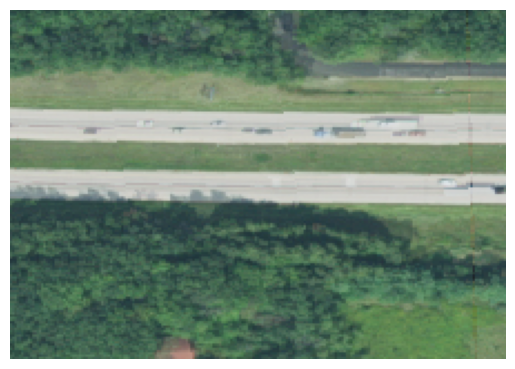

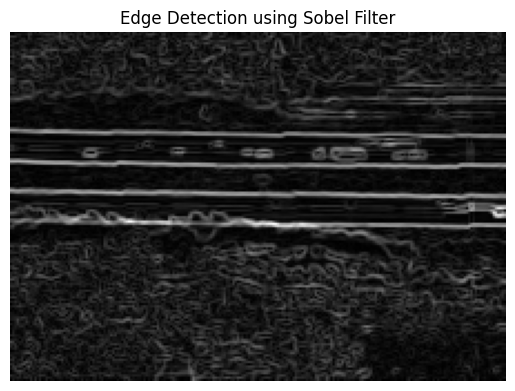

In [42]:
#Edge Detection
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to read and display an image
def read_and_display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return img

# Function for edge detection using Sobel filter
def sobel_edge_detection(img):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)

    # Apply Sobel filter
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=3)

    # Combine horizontal and vertical edges
    edges = np.sqrt(sobel_x**2 + sobel_y**2)

    # Normalize the edges
    edges = edges / np.max(edges)

    return edges

# Path to your satellite image in Google Drive
image_path = '/content/drive/MyDrive/Road Safety/naip2/naip1.tif'

# Read and display the original image
original_image = read_and_display_image(image_path)

# Perform Sobel edge detection
edges = sobel_edge_detection(original_image)

# Display the edge-detected image
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title('Edge Detection using Sobel Filter')
plt.show()


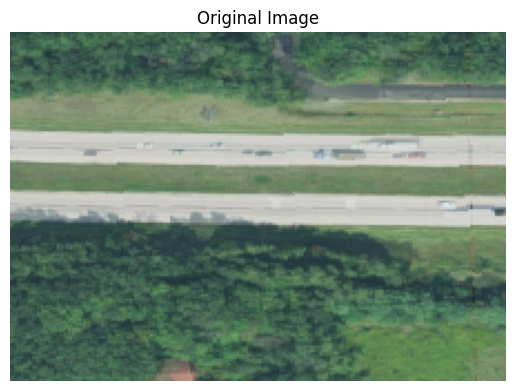

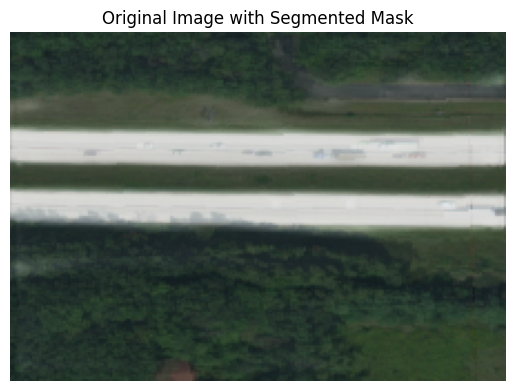

In [46]:
#Overlaying Images
import cv2
import numpy as np
from google.colab import drive
from PIL import Image
import matplotlib.pyplot as plt


def display_image(image, title):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()
# Function to overlay the original image with the segmented mask
def overlay_images(original_img, mask_img, alpha=0.5):
    # Resize the mask image to match the dimensions of the original image
    mask_img_resized = cv2.resize(mask_img, (original_img.shape[1], original_img.shape[0]))

    # Convert mask image to a 3-channel image
    mask_img_colored = cv2.cvtColor(mask_img_resized, cv2.COLOR_GRAY2RGB)

    # Blend the images using alpha blending
    overlay = cv2.addWeighted(original_img, 1 - alpha, mask_img_colored, alpha, 0)

    return overlay

# Read the original satellite image
original_image_path = '/content/drive/MyDrive/Road Safety/naip2/naip1.tif'
original_image = Image.open(original_image_path)
original_image_np = np.array(original_image)

# Read the segmented mask (replace with your segmentation result)
# For this example, I'm assuming you have a binary mask where road pixels are white (255) and background is black (0)
segmented_mask_path = '/content/drive/MyDrive/Road Safety/naip_test_Preds2/1_naip_pred.png'
segmented_mask = cv2.imread(segmented_mask_path, cv2.IMREAD_GRAYSCALE)

# Overlay the original image with the segmented mask
overlay_result = overlay_images(original_image_np, segmented_mask)
display_image(original_image_np,"Original Image")
# Display the result
plt.imshow(overlay_result)
plt.axis('off')
plt.title('Original Image with Segmented Mask')
plt.show()
